# fMRI Data Loading and Normalization in Python 

In cognitive neuroscience, what was considered impossible a few decades ago is now doable. Today, we can infer certain aspects of a person's cognitive processes from measurements of brain activity. This progress has come about due to a confluence of improvements in three different areas: computing speeds, brain imaging methods, and efficient machine learning algorithms. To use all three of these aspects for our data analysis, in an optimal manner, involves learning a complex sequence of steps. Our overarching goal for these exercises is to provide a step-by-step walk-through on how to execute these analysis steps and infer cognitive states from brain activity.

This process begins with running experiments and collecting fMRI data. Then, collected data undergo preprocessing, which involves corrections, transformations, and alignments. Only after these steps have been completed are the data ready for analysis by machine learning algorithms. Preprocessed fMRI data are commonly stored in the NIfTI format, the starting point for our analyses.

In this notebook, our aim is to cover the very first step in the analysis: the extraction and normalization of pre-processed fMRI data. We will use a localizer dataset from [Kim et al. (2017)](https://doi.org/10.1523/JNEUROSCI.3272-16.2017). This dataset will heretofore be referred to as the "vdc" dataset. For the localizer, subjects were shown blocks of faces, scenes and objects in 3 separate runs.

**Note:** If you need help understanding terms such as "localizer", "blocks", "runs", please read the glossary below and also do some self-study on fMRI terminology. This [talk series](https://cbmm.mit.edu/fmri-bootcamp) is a great starting place. If you would like to learn more about fMRI preprocessing, you can find some useful lecture material here: https://fsl.fmrib.ox.ac.uk/fslcourse/ (scroll down to 'Lecture slides & Practical Data').

### Goal of this notebook
This notebook will teach you how to visualize and normalize your data. Specifically, you will learn how to do the following:
 1. Load fMRI data into Python.
 2. Plot the timeseries for a voxel.
 3. Normalize the data with z-scoring.

## Table of Contents
[1. Import necessary packages](#import)  

[2. Load in timing files](#load_timing)  
>[2.1 Timing file description](#load_timing_describe)  
>[2.2 Plot stimulus presentation](#plot)  

[3. Load fMRI](#load_fmri)  
>[3.1 Plot voxel time series](#plot_voxel)  

[4. Normalization](#zscore)  
>[4.1 Check the z scoring](#zscore_check)  
>[4.2 Exploring a new dataset](#zscore_test)

[5. BIDS Formatted Data](#bids)



Exercises
>[Exercise 1](#ex1)   [2](#ex2)  [3](#ex3)  [4](#ex4)  [5](#ex5)  [6](#ex6)  [7](#ex7)  [8](#ex8)  [9](#ex9) 

>[Novel contribution](#novel) 

[Contributions](#contributions)


## 1. Import necessary packages <a id="import"></a> 
The following packages will be used:  
>nibabel: Read  fMRI data into Python arrays.  
>numpy: Perform numerical operations in Python.   
>scipy: Scientific computing methods.  
>nilearn: Used to extract masked fMRI data from a NIfTI file.  
>sklearn: Machine learning methods.  
>matplotlib, sns: Plotting libraries.  

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
import nibabel as nib
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
from scipy import stats
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
%matplotlib inline 
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

Autosaving every 5 seconds


### 1.1 Helper Functions

To make it easier for you to achieve the goals of this notebook, we have created helper functions that do the heavy lifting in terms of data extraction. Thus, a complex set of steps to load data, across NIfTI and MATLAB file formats, from multiple runs, is executed in few lines of code in this notebook. In future notebooks, you will be exposed to more details of data extraction. The helper functions are all in the `utils.py` script in this folder.

In [3]:
# Load some helper functions
from utils import load_vdc_stim_labels, load_vdc_mask, load_vdc_epi_data

# Load some constants
from utils import vdc_data_dir, vdc_all_ROIs, vdc_label_dict, vdc_n_runs, nb2_simulated_data

print('Data dir = %s' % (vdc_data_dir))
print('Regions of interest = %s' % (vdc_all_ROIs))
print('Labels = %s' % (vdc_label_dict))
print('Number of runs = %d' % (vdc_n_runs))

Data dir = /Users/aratzan/Downloads/brainiak_datasets/vdc
Regions of interest = ['FFA', 'PPA']
Labels = {1: 'Faces', 2: 'Scenes', 3: 'Objects'}
Number of runs = 3


<div class="alert alert-block alert-warning">
<strong> Note on data file paths:</strong> If you are running this notebook on your local machines you will need to pay attendtion to the data directory path. The data directory path variable points to a specific location. You will need to make a change to the data file path variable `vdc_data_dir` in `utils.py` based on where you download the dataset on your computer.  
<br>
<strong> No changes to the data path are needed if you are running on NeuroLibre or Google Colaboratory. </strong>
</div>

**Exercise 1:**<a id="ex1"></a> Describe the difference in functionality between 'import numpy' and 'from numpy import zeros':

**A:**

## 2. Load in timing files<a id="load_timing"></a>

The first way we are going to examine the vdc dataset is by looking at the timing of events in the experiment. The labels for each run of the experiment are stored in the localizer MATLAB file (e.g., `sub-01_localizer_01.mat`). We will read and plot the data that show which stimulus was presented at what time during the experiment. The columns in the localizer MATLAB file represent time in the experiment.

<div class="alert alert-block alert-warning">
Throughout these notebooks there will be self-study questions/suggestions. You are encouraged to explore these topics in order to expand your understanding of these topics and tools. </div>

**Self-study:** Navigate through the folder that contains these data (defined in `vdc_data_dir`) to get an understanding of the file structure. Open up the files and look at their contents. Be an explorer!

**If you are using the NeuroLibre binder to run these tutorials, you will not have easy access to view and open the files. You can download the vdc dataset from here: https://brainiak.org/tutorials/, onto your local machine, to view the files.**

**Glossary of common terms used to describe experiments**
>*stimulus*: The item that we wish to present to the participant in an experiment. Typically a picture or a sound. In the 'vdc' study, pictures of faces, places, and objects are shown to the participant.  
>*trial*: One presentation of the stimulus.  
>*block*: A sequence of trials of the same category. In the 'vdc' study, e.g. a block would consist of all face trials. Usually, multiple blocks are presented to the participant.  
>*run*: A sequence of blocks presented to the participant. Typically an experiment will have multiple runs. There are a few reasons for this:
>> *counter balancing*: If we started an experiment with faces, we want to also start with other categories to ensure there is no effect of the order of the category. This can be accomplished by having multiple runs, and manipulating the order of categories within runs.  
>> *rest time*: Continuously performing a task can lead to fatigue. In fMRI studies, participants get to relax between runs.  

>*TR*: Also known as Repetition Time. It is the time interval at which pulses occur and signal is collected. It can thus be considered as the sampling period of the BOLD signal. More details can be found here: https://mriquestions.com/tr-and-te.html

>*Localizers*: Every person has a unique brain anatomy. Thus, it becomes difficult to pinpoint an exact location in an individual that would be preferential to a stimulus e.g. faces, based on a study with other individuals. We could make an approximate guess of the location, but that would only be approximate. To get the precise location of a brain region in an individual that is sensitive to faces, we need to measure brain activity in that person when he/she is viewing faces. This helps localize the face preferred region in the brain of this individual and such experiments are called localizers. They are often used in conjunction with a main study to help localize a brain region preferential to a stimulus, in an individual, and this region is then used for further analysis in the main study. Localizers are typically block design experiments and are analyzed by contrasting the preferred stimuli with other stimuli. They are also used as independent determiners of the preferred stimulus to avoid circular inferences (more details will be covered in later notebooks). You can learn more about localizers here: 
Saxe, R., Brett, M., & Kanwisher, N. (2006). Divide and conquer: A defense of functional localizers. NeuroImage, 30(4), 1088–1096. https://doi.org/10.1016/j.neuroimage.2005.12.062


### 2.1 Timing file description <a id="load_timing_describe"></a>
The localizer task consists of 3 runs. Each run contained 15 blocks, with 5 blocks from each of 3 stimulus categories: faces, scenes and objects. There were 10 trials per block. Within a block, a stimulus was presented every 1.5s (1 TR). Between blocks, there were 15s (10 TRs) of fixation. Each run was approximately 310 TRs. 

There is a bunch of information about each run in the MATLAB stimulus file that we are about to load. Each row contains a different type of information (e.g., stimulus type, reaction time, etc.) and each column represents a different trial. 

Of most importance to us, the first row has the stimulus labels for the localizer runs; whereas the third row contains the time in seconds when the stimulus was presented (relative to the start of each run). The data were loaded in such a way that the three runs were concatenated in time, i.e., columns were added for each run.

The stimulus labels used in row 1 and their corresponding categories are as follows:  
1= Faces  
2= Scenes  
3= Objects 

<div class="alert alert-block alert-info">
<strong> Reminder: Python row and column indexing-- everything begins at [0], not [1].</strong>
<br>
When we refer to the first line of a file, and we call it row 1, it is indexed as row [0] in Python. Subsequently, each line number in a file (e.g., row n) will be indexed in Python as [n-1].
</div>

In [7]:
sub = 'sub-01'
stim_label_allruns = load_vdc_stim_labels(sub)
print('stim_label_allruns has shape: ', np.shape(stim_label_allruns))


stim_label_allruns has shape:  (10, 450)


<div class="alert alert-block alert-info">
<strong> Recommendation:</strong>  Because Python suppresses output (when there is no error), you may want to include print statements at the end of cells to indicate to you when a cell has executed all lines of code. This also is a useful technique to debug your programs. In Jupyter, there is an indicator to show that a cell is running - the asterisk '*' on the left hand side of the cell. Once the cell execution is complete, this changes to a number.
</div>

When analyzing data it is important to keep checking whether the code you wrote actually does what you intend it to do. For example, one possible thing to check is whether the created output variable stim_label_allruns indeed contains the expected number of rows and columns. We use a function from the imported numpy package for this purpose: np.shape(stim_label_allruns). Of course, there are plenty of other ways to check whether your code works the way you want it to work.

**Exercise 2:**<a id="ex2"></a> How big is the dataset in terms of number of subjects?



**A:**

### 2.2 Plot stimulus presentation <a id="plot_timing"></a>

We want to look at the sequence of stimulus presentations. Of course, you can look at the timeline of the stimulus presentation by selecting these rows and output them as an array of values (stim_label_allruns[0,:] and stim_label_allruns[2,:]).

**Self-study:** Don't know what a Python dictionary is? Look it up!


In [8]:
# choose a run 
run_id = 1

# select the corresponding time points for a given run
# The 6th row is the run identifier for a particular run.
time_points_mask = stim_label_allruns[5,:] == run_id

# the 1st row (index =0) is the labels of the stimuli 
labels = stim_label_allruns[0, time_points_mask]

# the 3rd row (index =2) is time in secs 
time_secs = stim_label_allruns[2, time_points_mask]

print('labels:\n\n %s \n\n' % labels)
print('time_secs:\n\n%s' % time_secs)

labels:

 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2.] 


time_secs:

[ 12.   13.5  15.   16.5  18.   19.5  21.   22.5  24.   25.5  42.   43.5
  45.   46.5  48.   49.5  51.   52.5  54.   55.5  72.   73.5  75.   76.5
  78.   79.5  81.   82.5  84.   85.5 102.  103.5 105.  106.5 108.  109.5
 111.  112.5 114.  115.5 132.  133.5 135.  136.5 138.  139.5 141.  142.5
 144.  145.5 162.  163.5 165.  166.5 168.  169.5 171.  172.5 174.  175.5
 192.  193.5 195.  196.5 198.  199.5 201.  202.5 204.  205.5 222.  223.5
 225.  226.5 228.  229.5 231.  232.5 234.  235.5 252.  253.5 255.  256.5
 258. 

However, a better way of visualizing the timeline of the stimulus presentation is by creating a plot, which we will now teach you by using the plotting package matplotlib (that you have imported earlier in this script). Here is one way to set up a plot:

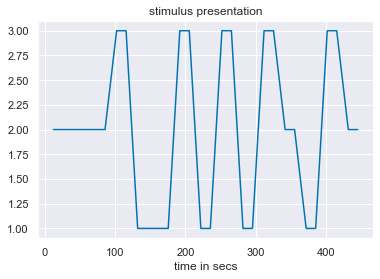

In [9]:
# Make an empty plot
plt.figure()

# Plot the data
plt.plot(time_secs, labels)

# you can add plot title like this
plt.title('stimulus presentation')

# you can set xlabel like this
plt.xlabel('time in secs');

We can set this up in a way that is a little more controllable (by capturing the figure and axis handles)

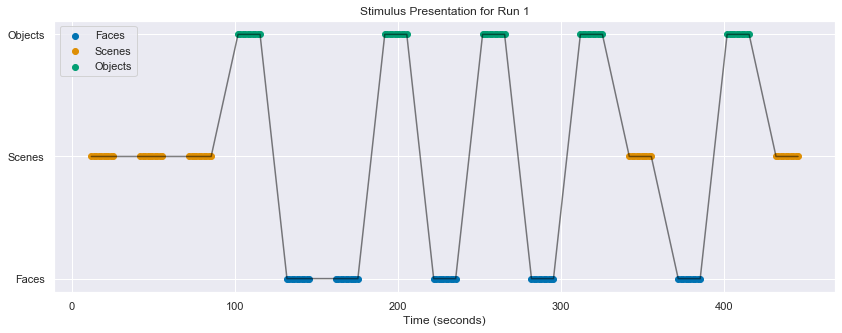

In [11]:
n_conditions = len(vdc_label_dict)
cur_pals = sns.color_palette('colorblind', n_colors=n_conditions)

# create a plotting panel 
f, ax = plt.subplots(1,1, figsize = (14, 5))

# plot the label for each condition
for i_cond in range(n_conditions): 
    label = list(vdc_label_dict.keys())[i_cond]
    temp_mask = label == labels
    ax.scatter(time_secs[temp_mask], labels[temp_mask], 
               color = cur_pals[i_cond], marker = 'o')
ax.legend(vdc_label_dict.values())

# connect the dots 
ax.plot(time_secs, labels, color = 'black', alpha = .5)

# mark the plot
ax.set_title('Stimulus Presentation for Run %d' % (run_id))
ax.set_yticks(list(vdc_label_dict.keys()))
ax.set_yticklabels(vdc_label_dict.values())
ax.set_xlabel('Time (seconds)');

**Exercise 3:**<a id="ex3"></a> Plot the stimulus presentation for runs 2 and 3 for this subject.

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2.]
[ 12.   13.5  15.   16.5  18.   19.5  21.   22.5  24.   25.5  42.   43.5
  45.   46.

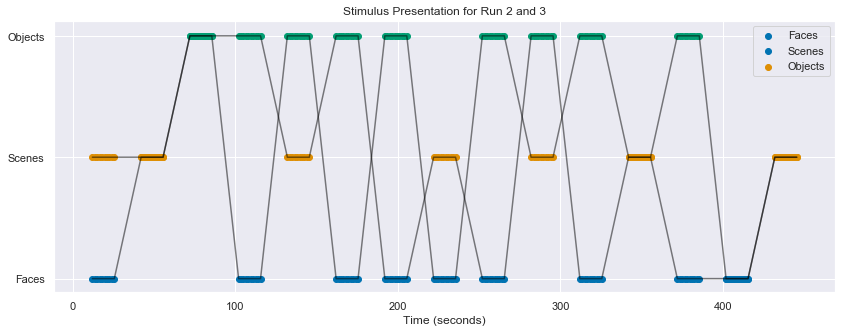

In [23]:
run_id = 2

time_points_mask = stim_label_allruns[5,:] == run_id

# the 1st row (index =0) is the labels of the stimuli 
labels2 = stim_label_allruns[0, time_points_mask]

# the 3rd row (index =2) is time in secs 
time_secs2 = stim_label_allruns[2, time_points_mask]

run_id = 3
time_points_mask = stim_label_allruns[5,:] == run_id

# the 1st row (index =0) is the labels of the stimuli 
labels3 = stim_label_allruns[0, time_points_mask]

# the 3rd row (index =2) is time in secs 
time_secs3 = stim_label_allruns[2, time_points_mask]


print(labels2)
print(labels3)

print(time_secs2)
print(time_secs3) #can plot over the same time frame
# Insert code here

#print(vdc_label_dict) #faces, scenes, objects. len 3
n_conditions = len(vdc_label_dict)
cur_pals = sns.color_palette('colorblind', n_colors=n_conditions)

# create a plotting panel 
f, ax = plt.subplots(1,1, figsize = (14, 5))

# plot the label for each condition
for i_cond in range(n_conditions): 
    label = list(vdc_label_dict.keys())[i_cond]
    temp_mask = label == labels2
    ax.scatter(time_secs2[temp_mask], labels2[temp_mask], 
               color = cur_pals[i_cond], marker = 'o')
    label = list(vdc_label_dict.keys())[i_cond]
    temp_mask = label == labels3
    ax.scatter(time_secs2[temp_mask], labels3[temp_mask], 
               color = cur_pals[i_cond], marker = 'o')
    
ax.legend(vdc_label_dict.values())

# connect the dots 
ax.plot(time_secs, labels2, color = 'black', alpha = .5)
ax.plot(time_secs, labels3, color = 'black', alpha = .5)


# mark the plot
ax.set_title('Stimulus Presentation for Run 2 and 3')
ax.set_yticks(list(vdc_label_dict.keys()))
ax.set_yticklabels(vdc_label_dict.values())
ax.set_xlabel('Time (seconds)');

**Exercise 4:**<a id="ex4"></a> Is the stimulus presented in the same order for all the three runs?

**A:**

## 3. Load fMRI data <a id="load_fmri"></a>

We'll load the data for one run. We will also extract a subset of the signal from the whole-brain data by using a mask for the "fusiform face area" ('FFA').

In [24]:
print('Here\'re the available ROIs: ', vdc_all_ROIs)

Here're the available ROIs:  ['FFA', 'PPA']


#### Get voxels from an ROI

We will extract BOLD data, only for voxels in a mask, by executing the following sequence of steps: 
1. Load whole brain fMRI data (for a given subject and a given run)
2. Load the mask of FFA 
3. Use `NiftiMasker` to sub-select FFA voxels from the whole brain data. This is a function from nilearn. Here's an [example](https://nilearn.github.io/auto_examples/04_manipulating_images/plot_mask_computation.html) about how to use it, and here's the official [documentation](https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html).

In [25]:
# choose FFA
ROI_name = 'FFA'

# 1. Load the fMRI data 
epi_data = load_vdc_epi_data(sub, run_id)

# 2. Load the mask file 
mask = load_vdc_mask(ROI_name, sub)

# 3. Apply ROI mask
nifti_masker = NiftiMasker(mask_img=mask)
maskedData = nifti_masker.fit_transform(epi_data) #fit and trasform the data based on the loaded mask 

print('Data shape - before masking: ', epi_data.shape)
print('Data shape - after masking: ', maskedData.shape)
print('Mask name: ', ROI_name)

Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
Loaded FFA mask
Data shape - before masking:  (128, 128, 52, 310)
Data shape - after masking:  (310, 5519)
Mask name:  FFA


**Self-study:** Not quite sure how the process of applying the mask worked in detail? Check out the documentation of the function we used (nilearn.input_data.NiftiMasker).

**Self-study:** The PPA is listed as an ROI in vdc_all_ROIs. What is the parahippocampal place area (PPA)?

### 3.1. Plot a voxel time-series <a id="plot_voxel"></a>

After masking, the fMRI dataset at this stage (found in the variable epi_mask_data that was created in the cell above) is in the format rows=time (i.e. 310 rows referring to 310 TRs) and columns=voxels (i.e. the number of voxels in your mask, FFA in this example).

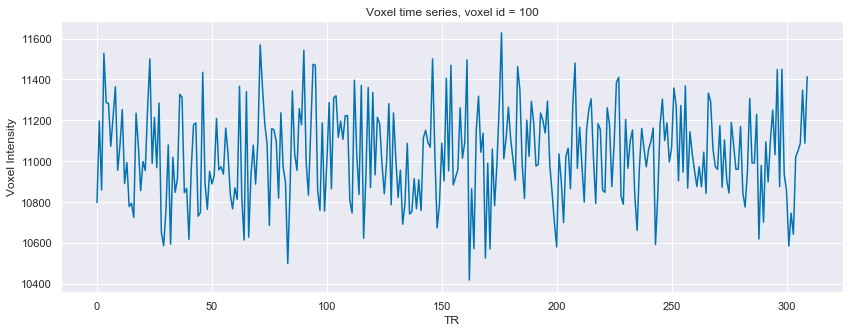

In [27]:
#rows --> time x columns --> voxels
# Plot a voxel value (in this example of voxel 100) through time
voxel_id = 100

f, ax = plt.subplots(1,1, figsize=(14,5))
ax.plot(maskedData[:, voxel_id])

ax.set_title('Voxel time series, voxel id = %d' % voxel_id)
ax.set_xlabel('TR')
ax.set_ylabel('Voxel Intensity');

## 4. Normalization <a id="zscore"></a>

Sometimes it is necessary to rescale data in order to make different sets of data more comparable. In machine learning, normalization is a standard preprocessing step, as described in [scikit-learn](http://scikit-learn.org/stable/modules/preprocessing.html). In fMRI, we often normalize in order to remove differences that may exist between runs or subjects for uninteresting reasons, such as scanner drift and to account for differences in variance.

There are many ways to normalize data. Z-scoring is one of the most common approaches: we center the data to mean of zero and a standard deviation of one ($\mu=0, \sigma = 1$).  

We will use the StandardScaler method for normalization. 

**Self-study:** Explore other normalization techniques in `scikit-learn` using the link above.

`StandardScaler` is a function from `sklearn.preprocessing`. `sklearn` functions tend to have the following generate usage: 

- Step 1: `sklearn_function.fit(some_data)`, which returns as fitted model
- Step 2: `sklearn_function.transform(some_data)`, which returns the transformed data 
 

In [28]:
# The following procedure normalizes the response within voxels over time
scaler = preprocessing.StandardScaler().fit(maskedData) #fit scaler on the data
maskedData_zscore = scaler.transform(maskedData) #normalize it 

#another way
scaler = preprocessing.StandardScaler()
scaler.fit(maskedData)
maskedData_zscore = scaler.transform(maskedData)

#yet another way
maskedData_zscore = preprocessing.StandardScaler().fit_transform(maskedData)


### 4.1 Check the z scoring <a id="zscore_check"></a>

The mean values never equal exactly zero, and the standard deviation is never exactly 1. This happens because of rounding and precision limitations. These small values are considered zero for most practical purposes. Below we print out the mean and standard deviation of individual voxels. 

In [29]:
voxel_mean = np.mean(maskedData_zscore, axis=0)
voxel_std = np.std(maskedData_zscore, axis=0)
print('The number of voxels in the mask is %d' % len(voxel_mean));
print('The mean of the first few voxels:\n', voxel_mean[0:4])
print('The std of the first few voxels:\n', voxel_std[0:4])

The number of voxels in the mask is 5519
The mean of the first few voxels:
 [ 4.6863670e-06 -1.6785438e-06 -1.9113863e-06  3.0871361e-06]
The std of the first few voxels:
 [1.0000001  0.99999976 1.0000001  1.0000001 ]


**Exercise 5:**<a id="ex5"></a> compared the raw data vs. the z-scored data

In [31]:
# Insert code here
raw_mean = np.mean(maskedData, axis = 0)
raw_std = np.std(maskedData, axis = 0)
print('The mean of the first few voxels:\n', voxel_mean[0:4])
print('The raw mean of the first few voxels:\n', raw_mean[0:4])

print('The std of the first few voxels:\n', voxel_std[0:4])
print('The raw std of the first few voxels:\n', raw_std[0:4])


The mean of the first few voxels:
 [ 4.6863670e-06 -1.6785438e-06 -1.9113863e-06  3.0871361e-06]
The raw mean of the first few voxels:
 [14311.748 14403.884 13058.278 13536.034]
The std of the first few voxels:
 [1.0000001  0.99999976 1.0000001  1.0000001 ]
The raw std of the first few voxels:
 [168.8722  200.9045  199.32744 199.07153]


**Exercise 6:**<a id="ex6"></a> Plot the distribution of values for a z-scored voxel as a histogram. Sample histogram code can be found [here.](https://matplotlib.org/examples/statistics/histogram_demo_histtypes.html)

(310, 5519)
(310,)


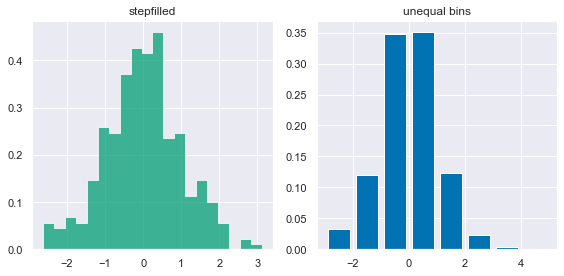

In [43]:
# Insert code here
# distribution of z-score values for one voxel as a histogram 

print(maskedData_zscore.shape) #310, 5519 
print(maskedData_zscore[:, 0].shape) #310 voxel recordings of this ID

x = maskedData_zscore[:, 0]
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 4))

ax0.hist(x, 20, normed=1, histtype='stepfilled', facecolor='g', alpha=0.75)
ax0.set_title('stepfilled')

# Create a histogram by providing the bin edges (unequally spaced).
bins = [-3,-2, -1, 0, 1, 2, 3, 4, 5]
ax1.hist(x, bins, normed=1, histtype='bar', rwidth=0.8)
ax1.set_title('unequal bins')

fig.tight_layout()
plt.show()


**Exercise 7:**<a id="ex7"></a> Z-score the data by writing your own code instead of using the StandardScaler() method.

Assign the Z-score data to `maskedData_normalized` 


In [ ]:
# Insert code here
maskedData_normalized = None # modify this to compute the z-score.

#subtract the mean of the data by each sample to obtain z-scored data 

In [44]:
if maskedData_normalized is not None:
    f, axes = plt.subplots(2,1,figsize = (14,9))
    v = 0
    t = 0 

    # Plot the results for the a feature vector at one time-point
    axes[0].plot(maskedData_normalized[:, v])
    axes[0].set_title('voxel-wise normalized BOLD time course (voxel id = %d)' % (v))
    axes[0].set_xlabel('TR')

    # Plot the time-series for one voxel
    axes[1].plot(maskedData_normalized[t, :])
    axes[1].set_title('voxel-wise normalized BOLD whole brain patttern (time = %d)' % (t))
    axes[1].set_xlabel('Voxel index')

    f.tight_layout()
else:
    print('Please assign Z-score values in the previous step to maskedData_normalized.')

NameError: name 'maskedData_normalized' is not defined

### 4.2 Exploring a new dataset<a id="zscore_test"></a>

We have a new dataset that needs some investigating. In this dataset, found in the **'lab1'** folder of the dataset repository, we have two conditions (Face, Scene) of a single participant's data while they viewed short blocks of faces and scenes, respectively (well actually, this is simulated data to prove an analytic point, but the point is an important one!). Four runs of data were simulated. We extracted data for the two conditions from the PPA and averaged the activity of all the voxels in that ROI. In an initial analysis we looked at the mean PPA activity of both conditions after subtracting the baseline (activity when nothing was on screen) and found that the Face condition had greater activation than the Scene condition in this participant. We did this by taking the time point labels and averaging all time points belonging to each condition.

The variables that loaded in are:  
`activity`: the average activity of an ROI, stored time point by time point, and concatenated across runs  
`cond_labels`: which condition does this time point belong to (1 means Face condition, 2 means Scene condition, 0 means neither [baseline])?  
`run_labels`: what run does this time point belong to?  

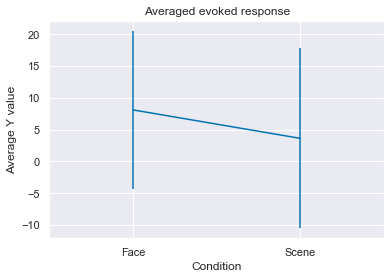

In [45]:
# Load in the data
activity = np.load(os.path.join(nb2_simulated_data, 'activity.npy'))
cond_labels = np.load(os.path.join(nb2_simulated_data,'cond_labels.npy'))
run_labels = np.load(os.path.join(nb2_simulated_data,'run_labels.npy'))

# When are the face, scene and baseline time points?
time_shift = 2 # We perform time shifting to account for the hemodynamic lag. This will explained in a future notebook
face_labels = np.where(cond_labels == 1)[0] + time_shift 
scene_labels = np.where(cond_labels == 2)[0] + time_shift
baseline_labels = np.where(cond_labels == 0)[0] + time_shift 

# Make sure the baseline labels don't exceed the maximum allowed (because of shifting)
baseline_labels = baseline_labels[baseline_labels < len(activity)]

# Pull out the time points corresponding to the block onset
face_activity = activity[face_labels]
scene_activity = activity[scene_labels]
baseline_activity = activity[baseline_labels]

# Get the difference from baseline for the two conditions
face_diff = face_activity - np.mean(baseline_activity)
scene_diff = scene_activity - np.mean(baseline_activity)

# Plot the data
plt.figure()
plt.errorbar([1, 2], [np.mean(face_diff), np.mean(scene_diff)], [np.std(face_diff), np.std(scene_diff)]);
plt.title('Averaged evoked response')
plt.xticks(labels=['Face', 'Scene'], ticks = [1, 2])
plt.ylabel('Average Y value')
plt.xlabel('Condition')
plt.xlim([0.5, 2.5]);

**Exercise 8:** <a id="ex8"></a> However, there is a problem: There is a quirk in this design that makes z-scoring a necessary step. If you were designing the study from scratch it could be avoided with a better experimental design, but we can use normalization to correct the problem. Search through the labels and data to identify the problem. Then use z-scoring to fix the problem and re-plot the result above, describing what has changed.

**Hint:** We *strongly* recommend that you plot the condition labels and the activity across the four runs.

In [53]:
# Put your code here for showing your working

# print("all activity: ", activity) #range 990-1050
# print("face activity: ", face_activity)
# print("scene activity", scene_activity)
# print("baseline activity: ", baseline_activity)

print(cond_labels)

print(run_labels)

[0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1
 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 2 2 2 2 2
 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0
 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 1 1
 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 0
 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 2 2 2 2 2 0 0 0
 0 0 0 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 1 1 1 1 1
 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0
 0 0 2 2 2 2 2 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 2 2
 2 2 2 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 0 0 0 0 0 1 1 1 1 1 

(904,)


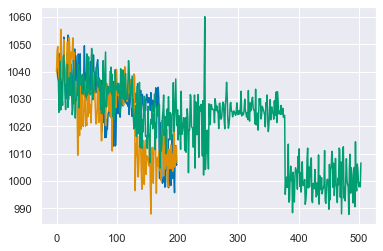

In [81]:
#line graph 
#Hint: We strongly recommend that you plot the condition labels and the activity across the four runs.
plt.figure()
print(cond_labels.shape)
num0s = 0
num1s = 0
num2s = 0

for i in range(cond_labels.shape[0]):
    if cond_labels[i] == 0:
        num0s += 1
    elif cond_labels[i] == 1:
        num1s +=1
    else:
        num2s += 1
        
#x = np.arange(0, run_labels.shape[0])
#plt.plot(x, activity) #with all activity
plt.plot(np.arange(0, num1s), face_activity) #only for face
plt.plot(np.arange(0, num2s), scene_activity) #only for scene
plt.plot(np.arange(2, num0s), baseline_activity) #only for baseline



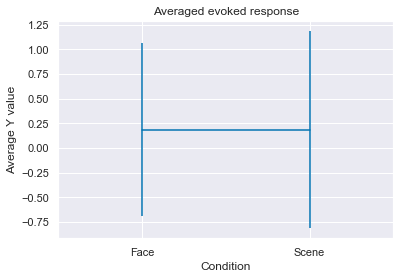

In [91]:
#try plotting with z score
#normalize data by taking total mean as opposed to just baseline 

activity = preprocessing.StandardScaler().fit_transform(activity)

# Pull out the time points corresponding to the block onset
face_activity = activity[face_labels]
scene_activity = activity[scene_labels]
baseline_activity = activity[baseline_labels]

# Get the difference from baseline for the two conditions

face_diff = (face_activity) - np.mean(face_activity) - np.mean(baseline_activity)
scene_diff = (scene_activity) -  np.mean(scene_activity) - np.mean(baseline_activity)

plt.figure()
plt.errorbar([1, 2], [np.mean(face_diff), np.mean(scene_diff)], [np.std(face_diff), np.std(scene_diff)]);
plt.title('Averaged evoked response')
plt.xticks(labels=['Face', 'Scene'], ticks = [1, 2])
plt.ylabel('Average Y value')
plt.xlabel('Condition')
plt.xlim([0.5, 2.5]);

**A**:

### 5. BIDS Formatted Data <a id="bids"></a>

The BIDS standard for neuroimaging data is being increasingly used to share data across laboratories. It enables open science practices and reproducibility. Instead of using arbitrary names for files, the BIDS format enforces a file naming structure, making it easy for other people to understand the various files. Detailed information on BIDS can be found here: https://bids.neuroimaging.io

Below, we show how to read in files written in the BIDS format. There are a few key elements in the file naming:
>`root folder`: This is where the data for all subjects is stored.  
>`func`: This folder is where all the functional neuroimaging data (epi) is stored. The `anat` folder stores the structural data. 

Keywords that are part of the file name:
>`ses`: The session that the data was acquired. Typically data acquired when a subject enters and leaves the scanner is counted as one session. Some studies could have participants return on other days and these would be counted as new sessions e.g ses-01, ses-02 etc. This keyword is used in the naming sub folders within a subject, as well as in the file name within a session.  
>`task`: This label typically describes what the experiment was about.  
>`space`: The orientation of the dataset. This could be T1w or MNI depending on the data.  
>`run`: The run id in which the volumes were acquired.  
>`bold`: This suffix denotes the type of data that is contained in the file. For fmri data it is 'bold'.  
The above keywords are always separated by underscores.


Using the above elements we can construct the file name. Note you will first need to download BIDS formatted data into an accessible folder and specify the path in `bids_folder` below. Once you have generated the file name, you can use Nilearn's data loading functions to read in the data.


In [92]:
bids_folder= 'bids_root_directory/' #specify path to BIDS folder
subj_bids='sub-01' # the subject id of the subject
ses_bids='ses-01' # the session information
#Using the above information, we can get the fMRI data file location.
file_loc= os.path.join(bids_folder,subj_bids,ses_bids,'func')
print('Directory where files are stored: %s' % file_loc)

#To get a specific file, we will need to add the following.
task_bids='faceplace' # the task name. change this for the specific dataset that you are using.
space_bids='T1w'  # space of the dataset
run_bids='01'     # the run id.
bids_file_name=  '%s_task-%s' % (subj_bids,task_bids) + '_space-%s' % space_bids + \
                    '_run-%s' % run_bids +'_bold.nii.gz'
print('BIDS file name: %s' % bids_file_name)
bids_full_path_to_file= os.path.join(file_loc,bids_file_name)

print('Full path to file: %s' % bids_full_path_to_file)


Directory where files are stored: bids_root_directory/sub-01/ses-01/func
BIDS file name: sub-01_task-faceplace_space-T1w_run-01_bold.nii.gz
Full path to file: bids_root_directory/sub-01/ses-01/func/sub-01_task-faceplace_space-T1w_run-01_bold.nii.gz


**Novel contribution:**<a id="novel"></a> Be creative and make one new discovery by adding an analysis, visualization, or optimization.

In [93]:
# Put novel contribution here
#can do a quick SVM to differentiate face/scene from nothing? 
#visualize the data 

data = nib.load(bids_full_path_to_file) #nii file 

FileNotFoundError: No such file or no access: 'bids_root_directory/sub-01/ses-01/func/sub-01_task-faceplace_space-T1w_run-01_bold.nii.gz'

## Contributions <a id="contributions"></a>

M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook 01/2018  
T. Meissner minor edits  
Q. Lu switch to matplotlib, color blind friendly colors, encapsulate helper functions, del ex.3 (loop)  
M. Kumar: Added Exercise 10, deleted masking exercise.  
K.A. Norman provided suggestions on the overall content and made edits to this notebook.  
C. Ellis: Incorporated comments from cmhn-s19.